In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ase.io import read
from ase import Atoms
from ase.build import mx2

import abtem
abtem.config.set({'fft':'fftw'})

# Frozen phonons

The atoms in real materials are not stationary, they vibrate around their position in the crystal due to thermal and zero-point vibrations. 

Vibrational scattering scattering (or electron-phonon scattering) is responsible for features including diffuse backgrounds and Kikuchi lines as well as for a large part of the high-angle scattering measured in annular dark-field measurements.

The frozen phonon approximation is a simple, if somewhat brute, approach to numerically simulate the effects of thermal vibrations. In the Frozen phonon approximation, the intensity is averaged over several frozen snapshots of the atomic model as it vibrates. Hence, each frozen phonon captures the atomic model with its atoms displaced by a different random offset.

## Kikuchi lines in SrTiO<sub>3</sub> 
We simulate SrTiO<sub>3</sub>(100) with frozen phonons. In order to observe visible Kikuchi lines, the sample needs some thickness, hence the unit cell is repeated 80 times along the $z$-direction. We also need too repeat the atoms in $x$ and $y$, otherwise the structure is just a repetition of the same unit with displaced atoms. 

In [2]:
atoms = read('data/srtio3.cif') * (5, 5, 50)

The `FrozenPhonons` displaces the atoms according to a Gaussian distribution (equivalent to the Einstein model of the density of states for phonons) using a random number generator with a given seed. 

The standard deviation of the Gaussian distribution may be provided as a single number for all atoms, for each element as a dictionary or for each atom as an array.

Below we create an ensemble of $12$ random atomic models, with a standard deviation of atomic displacements of $0.1 \ \mathrm{Å}$ and a seed of $100$.

In [3]:
frozen_phonons = abtem.FrozenPhonons(atoms, 
                                     num_configs = 10, 
                                     sigmas = .1, 
                                     seeds = 100)

```{warning}
We used too few 

```

The `FrozenPhonons` can be iterated to obtain the displaced atomic configurations. 

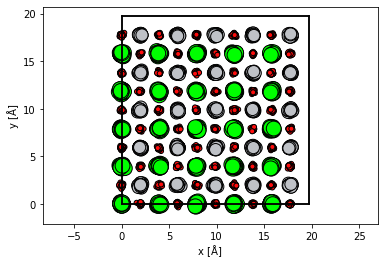

In [5]:
atoms_configuration = next(iter(frozen_phonons))

abtem.show_atoms(atoms_configuration, scale=.4);

The `FrozenPhonons` may be used as the `Atoms` to create a `Potential`. The potential now represents an ensemble of potentials with slightly displaced atomic configurations.

In [62]:
potential_phonons = abtem.Potential(frozen_phonons, 
                                    gpts = 512, 
                                    slice_thickness = 2)


potential_elastic = abtem.Potential(atoms, 
                                    gpts = 512, 
                                    slice_thickness = 2)

(0.038526660156249996, 0.038526660156249996)

If the potential is `build` the resulting `PotentialArray` is represented by a 4d array.

In [8]:
potential_phonons.build()

---------------------------------------------------------------------

type               label           coordinates
-----------------  --------------  --------------------
FrozenPhononsAxis  Frozen phonons  -
ThicknessAxis      z [Å]           1.99 3.98 ... 197.26
RealSpaceAxis      x [Å]           0.00 0.04 ... 19.69
RealSpaceAxis      y [Å]           0.00 0.04 ... 19.69

        bytes      shape               count      type
------  ---------  ------------------  ---------  -------------
array   0.97 GiB   (10, 99, 512, 512)  60 tasks   float32
chunks  99.00 MiB  (1, 99, 512, 512)   10 chunks  numpy.ndarray

We run a multislice simulation for a plane wave with an energy of $150 \ \mathrm{keV}$.

In [68]:
initial_waves = abtem.PlaneWave(energy=150e3)

exit_waves_phonons = initial_waves.multislice(potential_phonons).compute()
exit_waves_elastic = initial_waves.multislice(potential_elastic).compute()

[########################################] | 100% Completed | 11.8s
[########################################] | 100% Completed |  2.8s


The output is a stack of 12 exit waves; one for each potential in the frozen phonon ensemble.

In [69]:
exit_waves_phonons

--------------------------------------------------

type               label           coordinates
-----------------  --------------  -------------------
FrozenPhononsAxis  Frozen phonons  -
RealSpaceAxis      x [Å]           0.00 0.04 ... 19.69
RealSpaceAxis      y [Å]           0.00 0.04 ... 19.69

        bytes      shape           count     type
------  ---------  --------------  --------  -------------
array   20.00 MiB  (10, 512, 512)  -         complex64
chunks  -          -               - chunks  numpy.ndarray

We show the intensity of the one of the exit waves and the average intensity of the thermal ensemble. We observe that while the individual snapshots are noisy, this averages out in the thermal ensemble.

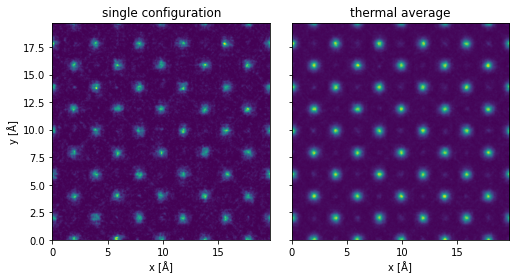

In [71]:
abtem.stack([
    exit_waves_phonons[0].intensity(),
    exit_waves_phonons.intensity().mean(0)
],
    ('single configuration', 'thermal average')
).show(explode=True, figsize=(12,4));

We show a comparison of the fully elastic model and the model including frozen phonons, the figures are shown on a common color scale.

In the model with phonons the higher order spots are significantly dampened, instead we see a significant amount of diffuse background scattering. The model with phonons also shows visible Kikuchi lines as bands radiating from the center and whereas Laue diffraction rings (also known as HOLZ lines) are significantly dampened.

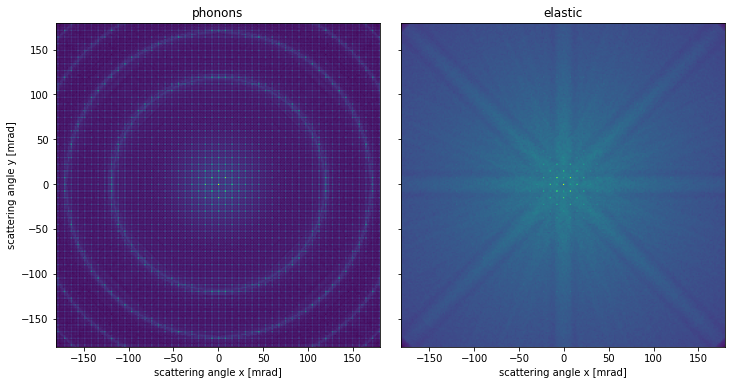

In [72]:
diffraction_patterns = abtem.stack([
    exit_waves_elastic.diffraction_patterns(max_angle='valid'),
    exit_waves_phonons.diffraction_patterns(max_angle='valid').mean(0),
],
    ('phonons', 'elastic')
)

diffraction_patterns.show(explode = True, 
                          power = .1, 
                          units = 'mrad', 
                          figsize = (12,6), 
                          common_color_scale = True);

## STEM simulation with frozen phonons

It is especially crucial to include Frozen phonons when high-angle scattering is important, such as in STEM with a HAADF detector. 

We create a `Probe` with an energy of $200 \ \mathrm{keV}$ and a convergence semi-angle of $20 \ \mathrm{mrad}$. We create a `LineScan` along the diagonal of a single periodic unit.

In [73]:
probe = abtem.Probe(energy=200e3, semiangle_cutoff = 20)

line_scan = abtem.LineScan.from_fractional_coordinates(potential_phonons, 
                                                       start = (0, 0), 
                                                       end = (1 / 5, 1 / 5))

We create task graph for scanned multislice, stack the resulting `LineProfiles` and `compute`.

In [74]:
measurements_phonons = probe.scan(potential_phonons, scan=line_scan)
measurements_elastic = probe.scan(potential_elastic, scan=line_scan)

measurements = abtem.stack(
    [measurements_phonons, measurements_elastic],
    ('phonons', 'elastic')
)

measurements.compute();

[########################################] | 100% Completed |  1min 23.1s


Below the fully elastic and phonon models are compared for two MAADF signals ($[50, 100] \ \mathrm{mrad}$ and $[50, 120] \ \mathrm{mrad}$) and HAADF signal ($[50, 200] \ \mathrm{mrad}$).

Both cases clearly demonstrates the importance of phonon scattering. The scattering in the phonon model is generally stronger, especially the background, however, on a strongly scattering column the elastic model may scatter slightly more strongly, as seen in the HAADF signal.

Comparing the two elastic MAADF signals we see how sensitive this model is to the inclusion of the first Laue diffraction ring, at $~110 \ \mathrm{mrad}$, in the integration range.  

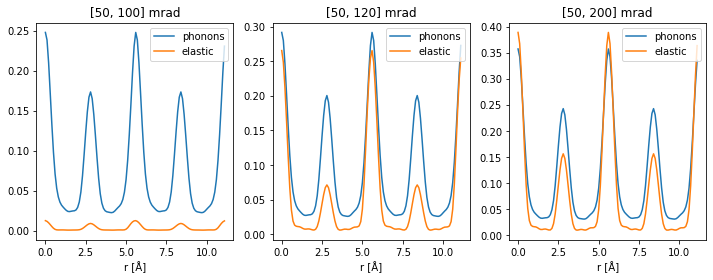

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
measurements.integrate_radial(inner=50, outer=100).interpolate(.1).tile(2).show(ax=ax1, title='[50, 100] mrad')
measurements.integrate_radial(inner=50, outer=120).interpolate(.1).tile(2).show(ax=ax2, title='[50, 120] mrad')
measurements.integrate_radial(inner=50, outer=200).interpolate(.1).tile(2).show(ax=ax3, title='[50, 200] mrad');